In [1]:
import igraph as ig
import coarse
import random

from data.graph_generator import *

nData = 60
nTasks = 26
edgeProb = 0.25

outgoingEdges = 2

avgDataDep = 4
stddDataDep = 3

g = generate_realistic(nData, nTasks, avgDataDep, stddDataDep)

# g = generate_graph(nData, nTasks, edgeProb)

# g = generate_barabasi(nData + nTasks, outgoingEdges)
# from data.testgraph3 import *

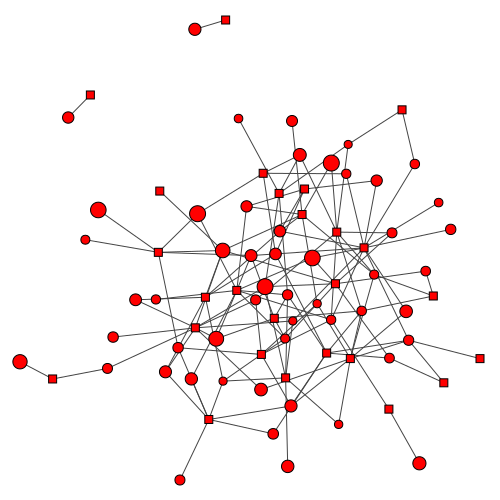

In [2]:
toDelete = []
for v in g.vs:
    if not v.neighbors():
        toDelete.append(v)
g.delete_vertices(toDelete)

volumes = g.vs["volume"]
maxVolume = max(volumes)

nVertices = len(g.vs)
nEdges = len(g.es)

visual_style = {}

layout = g.layout("fr")
visual_style["layout"] = layout

# g.vs["label"] = g.vs["name"]
# visual_style["vertex_label"] = g.vs["name"]
visual_style["vertex_size"] = [8 * (1 + volumes[i]/maxVolume) for i in range(nVertices)]
visual_style["bbox"] = (500, 500)
visual_style["margin"] = 20
visual_style["vertex_shape"] = ["circle" if g.vs[i]["name"][0] == 'd' else "square" for i in range(nVertices)]

# print("Vertex names:")
# print(["{0}: {1}".format(i, g.vs[i]["name"]) for i in range(len(g.vs))])
# print("\nWeighted edges")
# for e in g.es:
#     print("{0} -- {1}: {2}".format(g.vs[e.source]["name"], g.vs[e.target]["name"], e["weight"]))

ig.plot(g, **visual_style)

In [3]:
import numpy as np

nClusters = 3
clusters = range(nClusters)


costexp = 30
coststdd = 30

cost = [[0 for c1 in range(nClusters)] for c2 in range(nClusters)]
for c1 in range(nClusters):
    for c2 in range(c1+1, nClusters):
        cost[c1][c2] = max(round(random.gauss(costexp, coststdd),2),2.)
        cost[c2][c1] = cost[c1][c2]
cost = np.array(cost)

# cost = np.array([[0., 1.], [1.,0.]])

print(cost)

randomPart = [random.randint(0, nClusters-1) for i in range(len(g.vs))]
print(randomPart)

[[ 0.   73.76 47.73]
 [73.76  0.   30.07]
 [47.73 30.07  0.  ]]
[2, 1, 2, 0, 2, 1, 0, 2, 2, 0, 1, 1, 2, 2, 0, 0, 2, 1, 2, 1, 2, 0, 0, 1, 2, 2, 1, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 1, 1, 1, 0, 1, 2, 1, 1, 0, 2, 2, 2, 1, 0, 1, 2, 2, 0, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1]


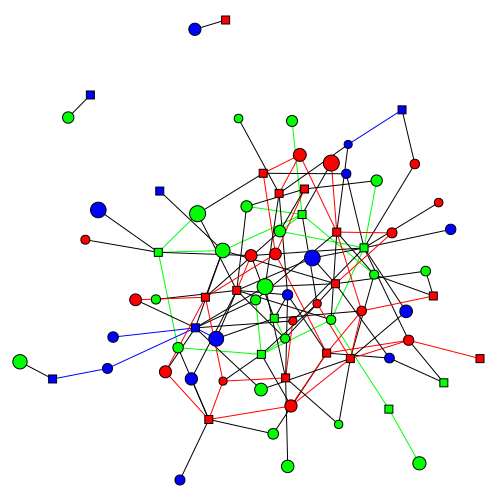

In [4]:
color_dict_vertex = {0: "blue", 1: "red", 2: "green", 3: "pink", 4: "orange" }
cutEdges = []
for e in g.es:
    if randomPart[e.source] != randomPart[e.target]:
        cutEdges.append(True)
#         commCost += g.es[e.index]["weight"] * cost[randomPart[e.source], randomPart[e.target]]
    else:
        cutEdges.append(False)
visual_style["vertex_color"] = [color_dict_vertex[randomPart[v]] for v in range(len(g.vs))]
visual_style["edge_color"] = ["black" if cutEdges[edg] else color_dict_vertex[randomPart[g.es[edg].source]] for edg in range(len(g.es))]
ig.plot(g, **visual_style)

In [5]:
import refining as ref

gain = ref.allGain(g, randomPart, nClusters, cost)
# print(gain)
# np.ndarray.sort(gain)
# print(gain)
tolerance = 0.2
loadPerCluster = sum(volumes) * (1+tolerance) / nClusters
loadLimits = [loadPerCluster for i in range(nClusters)]
availSpace = ref.freeSpace(g, randomPart, loadLimits)

sort_index = np.argsort(gain, axis=None)
sort_index2 = [(index // len(g.vs), index % len(g.vs)) for index in sort_index]
print(sort_index2)
sorted_gain = [gain[sort_index2[i][0], sort_index2[i][1]] for i in range(len(sort_index2))]
# for i in range(len(sort_index2)):
#     print(gain[sort_index2[i][0], sort_index2[i][1]])
# print(sorted_gain)

cutValue = 0
for edge in g.es:
    if randomPart[edge.source] != randomPart[edge.target]:
       cutValue += cost[randomPart[edge.source], randomPart[edge.target]] * edge["weight"]
    
print(cutValue)

refinedPart = ref.K_L(g, randomPart, nClusters, cost, loadLimits)

newValue = 0
for edge in g.es:
    if refinedPart[edge.source] != refinedPart[edge.target]:
       newValue += cost[refinedPart[edge.source], refinedPart[edge.target]] * edge["weight"]
    
print(newValue)

[(0, 67), (0, 56), (0, 41), (0, 47), (0, 44), (0, 77), (0, 23), (0, 39), (0, 68), (0, 61), (0, 16), (0, 42), (0, 63), (0, 46), (1, 61), (0, 38), (0, 55), (0, 10), (0, 43), (0, 18), (0, 76), (2, 41), (2, 44), (1, 58), (0, 65), (2, 67), (1, 46), (0, 69), (0, 13), (0, 53), (0, 32), (0, 30), (0, 37), (0, 51), (1, 9), (1, 56), (2, 23), (0, 8), (0, 57), (0, 12), (0, 25), (1, 53), (0, 7), (0, 35), (2, 9), (1, 28), (2, 63), (1, 48), (0, 73), (0, 60), (1, 8), (0, 0), (0, 4), (2, 37), (2, 43), (2, 51), (2, 28), (1, 62), (1, 0), (1, 36), (0, 24), (0, 75), (1, 13), (2, 38), (2, 73), (1, 55), (0, 29), (1, 24), (2, 77), (1, 30), (0, 11), (0, 26), (1, 70), (0, 2), (0, 20), (0, 1), (2, 17), (0, 52), (0, 5), (2, 11), (0, 49), (1, 63), (2, 13), (2, 12), (1, 59), (1, 60), (2, 8), (2, 7), (2, 4), (2, 2), (2, 0), (1, 76), (0, 21), (0, 22), (1, 75), (2, 16), (1, 69), (1, 68), (1, 67), (1, 66), (1, 65), (1, 64), (1, 77), (1, 73), (2, 24), (2, 20), (0, 3), (2, 62), (2, 61), (2, 58), (2, 56), (2, 55), (2, 53),

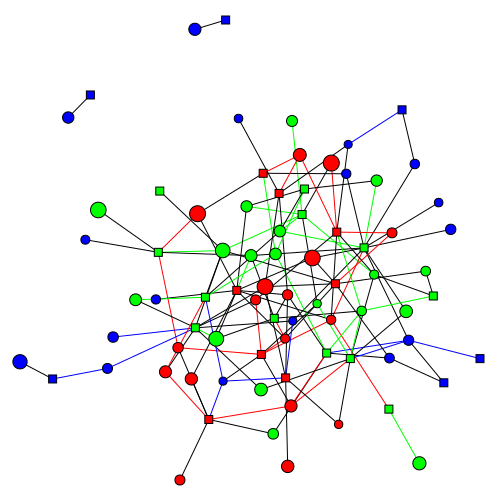

In [6]:
visual_style["vertex_color"] = [color_dict_vertex[refinedPart[v]] for v in range(len(g.vs))]
visual_style["edge_color"] = ["black" if cutEdges[edg] else color_dict_vertex[refinedPart[g.es[edg].source]] for edg in range(len(g.es))]
ig.plot(g, **visual_style)

In [7]:
print(ref.freeSpace(g, refinedPart, loadLimits))

[4.333999999999998, -0.10600000000000165, -0.1460000000000029]
